In [41]:
followings = ['\'']

productions = [
    'S\'->S',
    'S->(A)',
    'A->ABB',
    'A->B',
    'B->b',
    'B->c'
]
real_starting = 'S'
# productions = [
#     'S->E',
#     'E->aA',
#     'E->bB',
#     'A->cA',
#     'A->d',
#     'B->cB',
#     'B->d'
# ]
# real_starting = 'E'

In [42]:
programs = []
for production in productions:
    start = production.find('-')
    length = len(production)
    for i in range(start+1, length):
        if i == length - 1 or production[i+1] not in followings:
            programs.append(production[:i] + production[i] + '.' + production[i+1:])
            
print('基本LR(0)项目集为：')
for i in range(len(programs)):
    print('({0}) [{1}]'.format(i+1, programs[i]))
    
    
shiftings = []
shifting_ids = []
pending_for_reducings = []
pending_for_reducing_ids = []
reducings = []
reducing_ids = []
acceptings = []
accepting_ids = []
leng = len(programs)
for i in range(leng):
    length = len(programs[i])
    pos = programs[i].find('.')
    if pos == length - 1:
        if programs[i][pos-1] == real_starting:
            acceptings.append(programs[i])
            accepting_ids.append('(' + str(i+1) + ')')
        else:
            reducings.append(programs[i])
            reducing_ids.append('(' + str(i+1) + ')')
    else:
        if programs[i][pos+1].isupper():
            pending_for_reducings.append(programs[i])
            pending_for_reducing_ids.append('(' + str(i+1) + ')')
        else:
            shiftings.append(programs[i])
            shifting_ids.append('(' + str(i+1) + ')')

print('其中，', end='')
print('接受项目为：{0}'.format(accepting_ids[0]))
print('归约项目为：{0}'.format(' '.join(reducing_ids)))
print('待约项目为：{0}'.format(' '.join(pending_for_reducing_ids)))
print('移进项目为：{0}'.format(' '.join(shifting_ids)))

基本LR(0)项目集为：
(1) [S'->.S]
(2) [S'->S.]
(3) [S->.(A)]
(4) [S->(.A)]
(5) [S->(A.)]
(6) [S->(A).]
(7) [A->.ABB]
(8) [A->A.BB]
(9) [A->AB.B]
(10) [A->ABB.]
(11) [A->.B]
(12) [A->B.]
(13) [B->.b]
(14) [B->b.]
(15) [B->.c]
(16) [B->c.]
其中，接受项目为：(2)
归约项目为：(6) (10) (12) (14) (16)
待约项目为：(1) (4) (7) (8) (9) (11)
移进项目为：(3) (5) (13) (15)


In [53]:
def get_closure(closure):
    clos = closure.copy()
    for clo in clos:
        if clo in pending_for_reducings:
            pos = clo.find('.')
            for program in programs:
                pos_prog = program.find('.')
                if program not in clos and program[0] == clo[pos+1] and program[pos_prog-1] == '>':
                    clos.append(program)
    return clos

C = {}
traces = []
I_no = 0
def expand(pre_key, bridge, temp_I):
    global I_no
    
    temp_I_closure = get_closure(temp_I)
    if pre_key == 'init':
        C['I0'] = temp_I_closure
        pre_key = 'I0'
        for i in temp_I_closure:
            pos = i.find('.')
            if pos != len(i) - 1:
                new_I = [i[:pos] + i[pos+1] + '.' + i[pos+2:]]
                expand(pre_key, i[pos+1], new_I)
    else:
        pre_set = set(C[pre_key])
        temp_set = set(temp_I_closure)
        if pre_set == temp_set:
            traces.append('{0}->{1}->{2}'.format(pre_key, bridge, pre_key))
        else:
            for key, value in C.items():
                if value == temp_I_closure:
                    traces.append('{0}->{1}->{2}'.format(pre_key, bridge, key))
                    return
            
            new_key = None
            for trace in traces:
                trace_points = trace.split('->')
                if trace_points[0] == pre_key and trace_points[1] == bridge:
                    C[trace_points[2]] = C[trace_points[2]] + temp_I_closure
                    new_key = trace_points[2]
                    break
            if not new_key:
                I_no += 1
                new_key = pre_key[0] + str(I_no)
                C[new_key] = temp_I_closure
                traces.append('{0}->{1}->{2}'.format(pre_key, bridge, new_key))
            
            for i in temp_I_closure:
                pos = i.find('.')
                if pos != len(i) - 1:
                    new_I = [i[:pos] + i[pos+1] + '.' + i[pos+2:]]
                    expand(new_key, i[pos+1], new_I)

expand('init', None, [pending_for_reducings[0]])
from pprint import pprint
print('LR(0)项目集规范族为：')
pprint(C)
print('goto为：')
pprint(traces)

LR(0)项目集规范族为：
{'I0': ["S'->.S", 'S->.(A)'],
 'I1': ["S'->S."],
 'I2': ['S->(.A)', 'A->.ABB', 'A->.B', 'B->.b', 'B->.c'],
 'I3': ['S->(A.)', 'A->A.BB', 'B->.b', 'B->.c'],
 'I4': ['S->(A).'],
 'I5': ['A->AB.B', 'B->.b', 'B->.c'],
 'I6': ['A->ABB.'],
 'I7': ['B->b.'],
 'I8': ['B->c.'],
 'I9': ['A->B.']}
goto为：
['I0->S->I1',
 'I0->(->I2',
 'I2->A->I3',
 'I3->)->I4',
 'I3->B->I5',
 'I5->B->I6',
 'I5->b->I7',
 'I5->c->I8',
 'I3->b->I7',
 'I3->c->I8',
 'I2->B->I9',
 'I2->b->I7',
 'I2->c->I8']


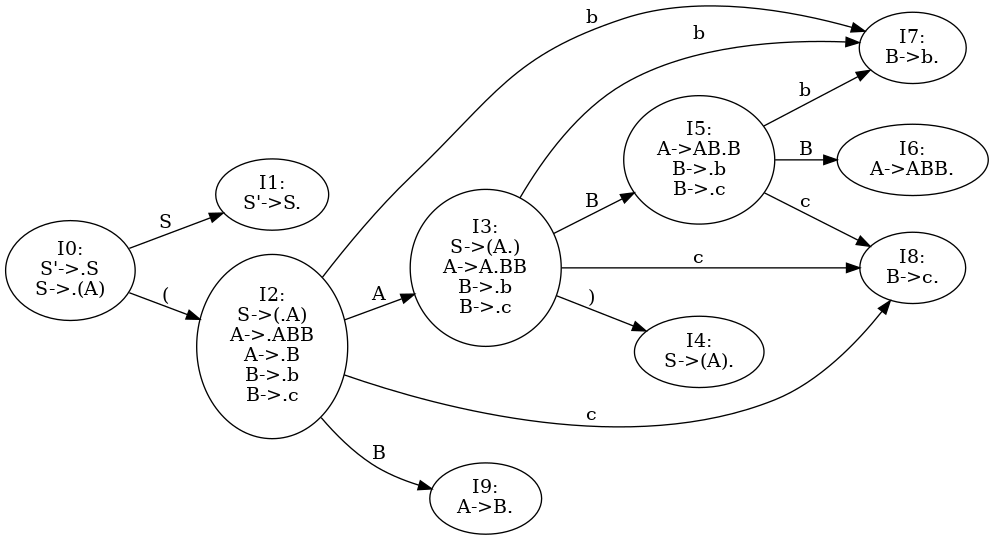

In [61]:
from graphviz import Digraph
fsm = Digraph(format='png')
fsm.graph_attr['rankdir'] = 'LR'

for key, value in C.items():
    fsm.node(key, key +':\n' + '\n'.join(value))
for trace in traces:
    trace_points = trace.split('->')
    fsm.edge(trace_points[0], trace_points[2], label=trace_points[1])
from IPython.display import display, Image
Image(fsm.render('output-fsm.gv'))

In [91]:
def insert_nested(nested, x, y, val):
    try:
        nested[x]
    except KeyError:
        nested[x] = {}
    try:
        nested[x][y]
    except KeyError:
        nested[x][y] = val
    
    if nested[x][y] is not None:
        first = nested[x][y]
        nested[x][y] = []
        nested[x][y].append(first)
        nested[x][y].append(val)
    
goto = {}
for trace in traces:
    trace_points = trace.split('->')
    insert_nested(goto, trace_points[0], trace_points[1], trace_points[2])
# pprint(goto)

def get_follow(Vn):
    pprint(productions)
    return input('plz input the follow set of {0}: '.format(Vn))

ACTION = {}
GOTO = {}
for key,value in C.items():
    key_no = key[1:]
    for val in value:
        pos = val.find('.')
        if pos != len(val) - 1 and not val[pos+1].isupper():
            insert_nested(ACTION, key_no, val[pos+1], 'S' + goto[key][val[pos+1]][1:])
            break
        if pos == len(val) - 1:
            if val[pos-1] == real_starting:
                insert_nested(ACTION, key_no, '#', 'acc')
            else:
                i_r = 0
                for i_r in range(len(productions)):
                    if productions[i_r] == val[:-1]:
                        break
                follows = eval(get_follow(val))
                if follows is not None:
                    for follow in follows:
                        insert_nested(ACTION, key_no, follow, 'r' + str(i_r))
                insert_nested(ACTION, key_no, '#', 'r' + str(i_r))
            break
        if val[pos+1].isupper():
            insert_nested(GOTO, key_no, val[pos+1], goto[key][val[pos+1]][1:])
        else:
            print('ERROR')

print('ACTION表：')
pprint(ACTION)
print('GOTO表：')
pprint(GOTO)

KeyError: 'S'